# DỊCH MÁY ANH–PHÁP / VỚI MÔ HÌNH ENCODER–DECODER LSTM


## 1. Cài đặt các thư viện




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
print("Installing dependencies...")
print("="*80)

!pip install spacy
!python -m spacy download en_core_web_sm
!python -m spacy download fr_core_news_sm
!pip install torchtext


try:
    import spacy
    spacy.load("en_core_web_sm")
    print("✓ en_core_web_sm already available")
except Exception:
    try:
        !python -m spacy download en_core_web_sm -q
        print("✓ en_core_web_sm downloaded via spacy")
    except Exception:
        !pip -q install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.8.0/en_core_web_sm-3.8.0-py3-none-any.whl
        print("✓ en_core_web_sm installed via direct wheel")

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
import spacy
import random
import math
import time
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import warnings
warnings.filterwarnings("ignore")


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\n✅ Setup completed!")
print(f"🖥️  Device: {device}")
if torch.cuda.is_available():
    print(f"🎮 GPU: {torch.cuda.get_device_name(0)}")
    print(f"💾 Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")


Installing dependencies...
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
      --------------------------------------- 0.3/12.8 MB ? eta -:--:--
     - -------------------------------------- 0.5/12.8 MB 1.7 MB/s eta 0:00:08
     - -------------------------------------- 0.5/12.8 MB 1.7 MB/s eta 0:00:08
     --- ------------------------------------ 1.0/12.8 MB 1.4 MB/s eta 0:00:09
     ---- ----------------------------------- 1.6/12.8 MB 1.6 MB/s eta 0:00:07
     ----- ---------------------------------- 1.8/12.8 MB 1.7 MB/s eta 0:00:07
     ------- -------------------------------- 2.4/12.8 MB 1.7 MB/s eta 0:00:06
     --------- ------------------------------ 3.1/12.8 

## 2. Tải MULTI30K Dataset

In [1]:
# ====== TẢI MULTI30K (EN–FR) VÀ LƯU VỀ MÁY ======

import os
import requests
import gzip
import io

BASE_URL = "https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/"

FILES_GZ = {
    "train.en": "train.en.gz",
    "train.fr": "train.fr.gz",
    "val.en":   "val.en.gz",
    "val.fr":   "val.fr.gz",
    "test.en":  "test_2016_flickr.en.gz",
    "test.fr":  "test_2016_flickr.fr.gz",
}

SAVE_DIR = "data"          # thư mục sẽ xuất hiện trên máy
os.makedirs(SAVE_DIR, exist_ok=True)

def download_and_save(url: str, out_path: str, timeout: int = 60):
    r = requests.get(url, timeout=timeout)
    r.raise_for_status()
    with gzip.open(io.BytesIO(r.content), "rt", encoding="utf-8") as f:
        lines = f.read()
    with open(out_path, "w", encoding="utf-8") as out:
        out.write(lines)
    return len(lines.splitlines())

print("Downloading Multi30K and saving to disk:")
for out_name, gz_name in FILES_GZ.items():
    url = BASE_URL + gz_name
    out_path = os.path.join(SAVE_DIR, out_name)
    try:
        n_lines = download_and_save(url, out_path)
        print(f"✓ {out_name}: {n_lines} lines")
    except Exception as e:
        print(f"✗ {out_name}: {type(e).__name__}: {e}")

print("\nDone. Files are saved in ./data/")


✓ train.en: 29000 lines
✓ train.fr: 29000 lines
✓ val.en: 1014 lines
✓ val.fr: 1014 lines
✓ test.en: 1000 lines
✓ test.fr: 1000 lines

Done. Files are saved in ./data/


In [2]:
print("\n" + "="*80)
print("TẢI MULTI30K (EN–FR)")
print("="*80)

import requests
import gzip
import io

BASE_URL = "https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/"

FILES_GZ = {
    "train.en": "train.en.gz",
    "train.fr": "train.fr.gz",
    "val.en":   "val.en.gz",
    "val.fr":   "val.fr.gz",
    "test.en":  "test_2016_flickr.en.gz",
    "test.fr":  "test_2016_flickr.fr.gz",
}

def _download_gz_lines(url: str, timeout: int = 60) -> list[str]:
    r = requests.get(url, timeout=timeout)
    r.raise_for_status()
    with gzip.open(io.BytesIO(r.content), "rt", encoding="utf-8") as f:
        return f.read().splitlines()

def download_multi30k():
    data = {}
    print("Downloading .gz files:")

    for key, fname in FILES_GZ.items():
        url = BASE_URL + fname
        try:
            lines = _download_gz_lines(url)
            data[key] = lines
            print(f"  ✓ {fname}: {len(lines)}")
        except Exception as e:
            print(f"  ✗ {fname}: {type(e).__name__}")

    n_train = len(data.get("train.en", []))
    n_val   = len(data.get("val.en", []))
    n_test  = len(data.get("test.en", []))

    print("\n📊 Dataset Statistics:")
    print(f"  • Train: {n_train:,}")
    print(f"  • Val:   {n_val:,}")
    print(f"  • Test:  {n_test:,}")
    return data

raw_data = download_multi30k()


TẢI MULTI30K (EN–FR)
  ✓ train.en.gz: 29000
  ✓ train.fr.gz: 29000
  ✓ val.en.gz: 1014
  ✓ val.fr.gz: 1014
  ✓ test_2016_flickr.en.gz: 1000
  ✓ test_2016_flickr.fr.gz: 1000

📊 Dataset Statistics:
  • Train: 29,000
  • Val:   1,014
  • Test:  1,000


## 3. TOKENIZATION VỚI SPACY

In [3]:
print("\n" + "="*80)
print("TOKENIZE với SPACY")
print("="*80)

import spacy
from tqdm import tqdm

print("Loading spaCy models...")
spacy_en = spacy.load("en_core_web_sm")
spacy_fr = spacy.load("fr_core_news_sm")
print("  ✓ en_core_web_sm")
print("  ✓ fr_core_news_sm")

def preprocess_text(text: str) -> str:
    return " ".join(text.split()).lower()

def tokenize_en(text: str) -> list[str]:
    text = preprocess_text(text)
    return [tok.text for tok in spacy_en.tokenizer(text)]

def tokenize_fr(text: str) -> list[str]:
    text = preprocess_text(text)
    return [tok.text for tok in spacy_fr.tokenizer(text)]

print("\nTokenizing datasets...")
train_en = [tokenize_en(s) for s in tqdm(raw_data["train.en"], desc="Train EN")]
train_fr = [tokenize_fr(s) for s in tqdm(raw_data["train.fr"], desc="Train FR")]
val_en   = [tokenize_en(s) for s in tqdm(raw_data["val.en"],   desc="Val EN")]
val_fr   = [tokenize_fr(s) for s in tqdm(raw_data["val.fr"],   desc="Val FR")]
test_en  = [tokenize_en(s) for s in tqdm(raw_data["test.en"],  desc="Test EN")]
test_fr  = [tokenize_fr(s) for s in tqdm(raw_data["test.fr"],  desc="Test FR")]

print("\n📌 Tokenization example:")
print("EN raw :", raw_data["train.en"][0])
print("EN tok :", train_en[0])
print("FR raw :", raw_data["train.fr"][0])
print("FR tok :", train_fr[0])


TOKENIZE với SPACY
Loading spaCy models...
  ✓ en_core_web_sm
  ✓ fr_core_news_sm

Tokenizing datasets...


Test FR: 100%|██████████| 1000/1000 [00:00<00:00, 30094.31it/s]


📌 Tokenization example:
EN raw : Two young, White males are outside near many bushes.
EN tok : ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']
FR raw : Deux jeunes hommes blancs sont dehors près de buissons.
FR tok : ['deux', 'jeunes', 'hommes', 'blancs', 'sont', 'dehors', 'près', 'de', 'buissons', '.']


## 4. Xây dựng Vocabulary

In [4]:
print("\n" + "="*80)
print("XÂY DỰNG VOCABULARY")
print("="*80)

from collections import Counter

class Vocabulary:
    def __init__(self, freq_threshold=2, top_k=10000):
        self.itos = {0: "<pad>", 1: "<sos>", 2: "<eos>", 3: "<unk>"}
        self.stoi = {"<pad>": 0, "<sos>": 1, "<eos>": 2, "<unk>": 3}
        self.freq_threshold = freq_threshold
        self.top_k = top_k

    def __len__(self):
        return len(self.itos)

    def build_vocabulary(self, sentence_list):
        frequencies = Counter()
        idx = 4
        for sentence in sentence_list:
            frequencies.update(sentence)
        for word, count in frequencies.most_common(self.top_k):
            if count >= self.freq_threshold:
                self.stoi[word] = idx
                self.itos[idx] = word
                idx += 1

    def numericalize(self, tokens):
        unk = self.stoi["<unk>"]
        return [self.stoi.get(tok, unk) for tok in tokens]


print("Building vocabularies...")
en_vocab = Vocabulary(freq_threshold=2, top_k=10000)
fr_vocab = Vocabulary(freq_threshold=2, top_k=10000)

en_vocab.build_vocabulary(train_en)
fr_vocab.build_vocabulary(train_fr)

print("\n📊 Vocabulary Statistics:")
print(f"  • English vocab size: {len(en_vocab):,}")
print(f"  • French vocab size:  {len(fr_vocab):,}")

print("\n🏷️  Special Tokens (EN vocab):")
print(f"  • <pad>: {en_vocab.stoi['<pad>']}")
print(f"  • <sos>: {en_vocab.stoi['<sos>']}")
print(f"  • <eos>: {en_vocab.stoi['<eos>']}")
print(f"  • <unk>: {en_vocab.stoi['<unk>']}")

example = train_en[0][:5]
print("\n📝 Numericalization Example:")
print(f"  Tokens:  {example}")
print(f"  Indices: {en_vocab.numericalize(example)}")



XÂY DỰNG VOCABULARY
Building vocabularies...

📊 Vocabulary Statistics:
  • English vocab size: 5,892
  • French vocab size:  6,470

🏷️  Special Tokens (EN vocab):
  • <pad>: 0
  • <sos>: 1
  • <eos>: 2
  • <unk>: 3

📝 Numericalization Example:
  Tokens:  ['two', 'young', ',', 'white', 'males']
  Indices: [16, 24, 15, 25, 774]


## 5. Dataset và Dataloader

In [5]:
print("\n" + "="*80)
print("DATASET & DATALOADER")
print("="*80)

import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

class TranslationDataset(Dataset):
    def __init__(self, src_data, trg_data, src_vocab, trg_vocab):
        self.src_data = src_data
        self.trg_data = trg_data
        self.src_vocab = src_vocab
        self.trg_vocab = trg_vocab

    def __len__(self):
        return len(self.src_data)

    def __getitem__(self, idx):
        src_tokens = self.src_data[idx]
        trg_tokens = self.trg_data[idx]

        src_ids = self.src_vocab.numericalize(src_tokens)
        trg_ids = (
            [self.trg_vocab.stoi["<sos>"]]
            + self.trg_vocab.numericalize(trg_tokens)
            + [self.trg_vocab.stoi["<eos>"]]
        )

        return torch.tensor(src_ids, dtype=torch.long), torch.tensor(trg_ids, dtype=torch.long)


def collate_fn(batch, pad_idx=0):
    src_list, trg_list = zip(*batch)
    src_lengths = torch.tensor([len(s) for s in src_list], dtype=torch.long)
    src_batch = pad_sequence(src_list, batch_first=True, padding_value=pad_idx)
    trg_batch = pad_sequence(trg_list, batch_first=True, padding_value=pad_idx)

    src_lengths, sort_idx = src_lengths.sort(descending=True)
    src_batch = src_batch[sort_idx]
    trg_batch = trg_batch[sort_idx]

    return src_batch, src_lengths, trg_batch

BATCH_SIZE = 64
train_dataset = TranslationDataset(train_en, train_fr, en_vocab, fr_vocab)
val_dataset = TranslationDataset(val_en, val_fr, en_vocab, fr_vocab)
test_dataset = TranslationDataset(test_en, test_fr, en_vocab, fr_vocab)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

print("✅ Dataloaders created!")

print(f"  • Batch size: {BATCH_SIZE}")
print(f"  • Train batches: {len(train_loader)}")
print(f"  • Val  batches:  {len(val_loader)}")
print(f"  • Test batches:  {len(test_loader)}")

src_sample, src_lengths_sample, trg_sample = next(iter(train_loader))
print(f"\n📊 Sample Batch Shapes:")
print(f"  • Source: {src_sample.shape}")
print(f"  • Source lengths: {src_lengths_sample.shape}  (min={src_lengths_sample.min().item()}, max={src_lengths_sample.max().item()})")
print(f"  • Target: {trg_sample.shape}")



DATASET & DATALOADER
✅ Dataloaders created!
  • Batch size: 64
  • Train batches: 454
  • Val  batches:  16
  • Test batches:  16

📊 Sample Batch Shapes:
  • Source: torch.Size([64, 25])
  • Source lengths: torch.Size([64])  (min=7, max=25)
  • Target: torch.Size([64, 34])


## 6. Model
### 6.1 Fixed-Length Encoder-Decoder (No Attention)

In [6]:
print("\n" + "="*80)
print("FIXED-LENGTH ENCODER-DECODER (NO ATTENTION)")
print("="*80)
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hidden_dim, n_layers, dropout, pad_idx=0):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim, padding_idx=pad_idx)
        self.dropout = nn.Dropout(dropout)
        self.lstm = nn.LSTM(emb_dim, hidden_dim, n_layers, dropout=dropout if n_layers > 1 else 0, batch_first=True)

    def forward(self, src, src_lengths, return_outputs=False):
        embedded = self.dropout(self.embedding(src))
        packed = pack_padded_sequence(embedded, src_lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_out, (hidden, cell) = self.lstm(packed)
        outputs, _ = pad_packed_sequence(packed_out, batch_first=True)
        if return_outputs:
            return hidden, cell, outputs
        return hidden, cell


class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hidden_dim, n_layers, dropout, pad_idx=0):
        super().__init__()
        self.output_dim = output_dim
        self.embedding = nn.Embedding(output_dim, emb_dim, padding_idx=pad_idx)
        self.dropout = nn.Dropout(dropout)
        self.lstm = nn.LSTM(emb_dim, hidden_dim, n_layers, dropout=dropout, batch_first=True)
        self.fc_out = nn.Linear(hidden_dim, output_dim)

    def forward(self, input, hidden, cell):
        input = input.unsqueeze(1)
        embedded = self.dropout(self.embedding(input))
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        prediction = self.fc_out(output.squeeze(1))
        return prediction, hidden, cell
print("✅ Decoder class defined!")


FIXED-LENGTH ENCODER-DECODER (NO ATTENTION)
✅ Decoder class defined!


### 6.2 Seq2Seq Model

In [7]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, src_lengths, trg, teacher_forcing_ratio=0.5):
        batch_size = src.shape[0]
        trg_len = trg.shape[1]
        trg_vocab_size = self.decoder.output_dim
        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(self.device)
        hidden, cell = self.encoder(src, src_lengths)
        input = trg[:, 0]
        for t in range(1, trg_len):
            output, hidden, cell = self.decoder(input, hidden, cell)
            outputs[:, t, :] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = trg[:, t] if teacher_force else top1
        return outputs

EMBEDDING_DIM = 256
HIDDEN_DIM = 512
N_LAYERS = 2
DROPOUT = 0.4
TEACHER_FORCING_RATIO = 0.5

INPUT_DIM = len(en_vocab)
OUTPUT_DIM = len(fr_vocab)
encoder = Encoder(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, N_LAYERS, DROPOUT)
decoder = Decoder(OUTPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, N_LAYERS, DROPOUT)
model = Seq2Seq(encoder, decoder, device).to(device)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("✅ Seq2Seq model initialized!")
print(f"\nModel Statistics:")
print(f"  • Total parameters: {count_parameters(model):,}")
print(f"  • Encoder params:   {count_parameters(encoder):,}")
print(f"  • Decoder params:   {count_parameters(decoder):,}")

print(f"\nHyperparameters:")
print(f"  • Hidden size:         {HIDDEN_DIM}")
print(f"  • Embedding dim:       {EMBEDDING_DIM}")
print(f"  • LSTM layers:         {N_LAYERS}")
print(f"  • Dropout:             {DROPOUT}")
print(f"  • Teacher forcing:     {TEACHER_FORCING_RATIO}")

✅ Seq2Seq model initialized!

Model Statistics:
  • Total parameters: 13,840,198
  • Encoder params:   5,186,560
  • Decoder params:   8,653,638

Hyperparameters:
  • Hidden size:         512
  • Embedding dim:       256
  • LSTM layers:         2
  • Dropout:             0.4
  • Teacher forcing:     0.5


## 7. Training Function

In [8]:
print("\n" + "="*80)
print("ĐỊNH NGHĨA HÀM TRAINING")
print("="*80)


def train_epoch(model, iterator, optimizer, criterion, clip, device, tf_ratio=None):
    if tf_ratio is None:
        tf_ratio = TEACHER_FORCING_RATIO
    model.train()
    epoch_loss = 0
    for src, src_lengths, trg in tqdm(iterator, desc="Training", leave=False):
        src, trg = src.to(device), trg.to(device)
        optimizer.zero_grad()
        output = model(src, src_lengths, trg, teacher_forcing_ratio=tf_ratio)
        output_dim = output.shape[-1]
        output = output[:, 1:, :].reshape(-1, output_dim)
        trg_flat = trg[:, 1:].reshape(-1)
        loss = criterion(output, trg_flat)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion, device, tf_ratio=0):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for src, src_lengths, trg in tqdm(iterator, desc="Evaluating", leave=False):
            src, trg = src.to(device), trg.to(device)
            output = model(src, src_lengths, trg, teacher_forcing_ratio=tf_ratio)
            output_dim = output.shape[-1]
            output = output[:, 1:, :].reshape(-1, output_dim)
            trg_flat = trg[:, 1:].reshape(-1)
            loss = criterion(output, trg_flat)
            epoch_loss += loss.item()
    return epoch_loss / len(iterator)



PAD_IDX = fr_vocab.stoi["<pad>"]
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = optim.Adam(model.parameters(), lr=0.001)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2
)

print("✅ Training functions defined!")
print(f"\nTraining Configuration:")
print(f"  • Loss:         CrossEntropyLoss(ignore_index={PAD_IDX})")
print(f"  • Optimizer:    Adam(lr=0.001)")
print(f"  • Scheduler:    ReduceLROnPlateau")
print(f"  • Gradient clip: 1.0")


ĐỊNH NGHĨA HÀM TRAINING
✅ Training functions defined!

Training Configuration:
  • Loss:         CrossEntropyLoss(ignore_index=0)
  • Optimizer:    Adam(lr=0.001)
  • Scheduler:    ReduceLROnPlateau
  • Gradient clip: 1.0


## 8. Training

In [9]:
print("\n" + "="*80)
print("TRAINING")
print("="*80)

N_EPOCHS = 20
CLIP = 1
PATIENCE = 3
best_valid_loss = float('inf')
patience_counter = 0

train_losses = []
val_losses = []


for epoch in range(N_EPOCHS):
    start_time = time.time()

    # Training step
    train_loss = train_epoch(model, train_loader, optimizer, criterion, CLIP, device)

    # Evaluate on validation set
    valid_loss = evaluate(model, val_loader, criterion, device)

    end_time = time.time()
    epoch_mins, epoch_secs = divmod(end_time - start_time, 60)


    train_losses.append(train_loss)
    val_losses.append(valid_loss)



    print(f'Epoch {epoch+1} | Train Loss: {train_loss:.3f} | Validation Loss: {valid_loss:.3f} | Time: {epoch_mins}m {epoch_secs}s')



    # Early stopping logic (nếu cần)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), 'best_model.pth')
        print('  ✅ Best model saved!')
    else:
        patience_counter += 1
        print(f'  ⏳ Patience: {patience_counter}/{PATIENCE}')

    # Early stopping condition
    if patience_counter >= PATIENCE:
        print(f'\n⚠️ Early stopping at epoch {epoch+1}')
        break


TRAINING


Epoch 1 | Train Loss: 4.779 | Validation Loss: 4.687 | Time: 15.0m 33.68210983276367s
  ✅ Best model saved!


Epoch 2 | Train Loss: 3.889 | Validation Loss: 4.245 | Time: 15.0m 40.91281175613403s
  ✅ Best model saved!


Epoch 3 | Train Loss: 3.452 | Validation Loss: 3.982 | Time: 15.0m 9.641393184661865s
  ✅ Best model saved!


Epoch 4 | Train Loss: 3.148 | Validation Loss: 3.826 | Time: 16.0m 53.63371682167053s
  ✅ Best model saved!


Epoch 5 | Train Loss: 2.880 | Validation Loss: 3.755 | Time: 24.0m 26.438888788223267s
  ✅ Best model saved!


Epoch 6 | Train Loss: 2.700 | Validation Loss: 3.599 | Time: 30.0m 33.292152404785156s
  ✅ Best model saved!


Epoch 7 | Train Loss: 2.542 | Validation Loss: 3.532 | Time: 30.0m 20.758237600326538s
  ✅ Best model saved!


Epoch 8 | Train Loss: 2.390 | Validation Loss: 3.480 | Time: 30.0m 6.608781337738037s
  ✅ Best model saved!


Epoch 9 | Train Loss: 2.279 | Validation Loss: 3.478 | Time: 121.0m 49.224201917648315s
  ✅ Best model saved!


Epoch 10 | Train Loss: 2.156 | Validation Loss: 3.399 | Time: 21.0m 3.6688997745513916s
  ✅ Best model saved!


Epoch 11 | Train Loss: 2.076 | Validation Loss: 3.324 | Time: 23.0m 18.695294618606567s
  ✅ Best model saved!


Epoch 12 | Train Loss: 1.973 | Validation Loss: 3.328 | Time: 22.0m 33.97131061553955s
  ⏳ Patience: 1/3


Epoch 13 | Train Loss: 1.892 | Validation Loss: 3.316 | Time: 14.0m 14.251840114593506s
  ✅ Best model saved!


Epoch 14 | Train Loss: 1.816 | Validation Loss: 3.283 | Time: 12.0m 53.958144187927246s
  ✅ Best model saved!


Epoch 15 | Train Loss: 1.748 | Validation Loss: 3.328 | Time: 12.0m 13.089281797409058s
  ⏳ Patience: 1/3


Epoch 16 | Train Loss: 1.677 | Validation Loss: 3.370 | Time: 13.0m 10.635494947433472s
  ⏳ Patience: 2/3


Epoch 17 | Train Loss: 1.599 | Validation Loss: 3.409 | Time: 13.0m 21.5388605594635s
  ⏳ Patience: 3/3

⚠️ Early stopping at epoch 17


## 9. Vẽ đường training


TÓM TẮT BEST EPOCH (THEO VAL LOSS)


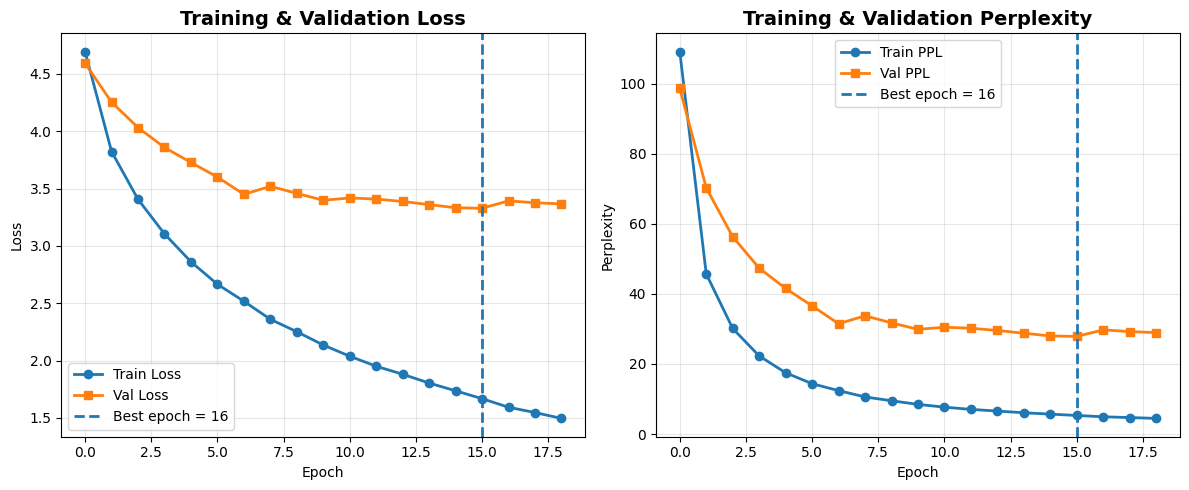

✅ Saved: training_curves.png


In [10]:
print("\n" + "="*80)
print("TÓM TẮT BEST EPOCH (THEO VAL LOSS)")
print("="*80)
# Vẽ đồ thị Train Loss và Validation Loss trong suốt quá trình huấn luyện
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss", marker="o", linewidth=2)
plt.plot(val_losses, label="Val Loss", marker="s", linewidth=2)
plt.axvline(np.argmin(val_losses), linestyle="--", linewidth=2, label=f"Best epoch = {np.argmin(val_losses) + 1}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss", fontsize=14, fontweight="bold")
plt.legend()
plt.grid(True, alpha=0.3)

# Perplexity
plt.subplot(1, 2, 2)
train_ppl = [math.exp(x) for x in train_losses]
val_ppl = [math.exp(x) for x in val_losses]
plt.plot(train_ppl, label="Train PPL", marker="o", linewidth=2)
plt.plot(val_ppl, label="Val PPL", marker="s", linewidth=2)
plt.axvline(np.argmin(val_losses), linestyle="--", linewidth=2, label=f"Best epoch = {np.argmin(val_losses) + 1}")
plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.title("Training & Validation Perplexity", fontsize=14, fontweight="bold")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("training_curves.png", dpi=150, bbox_inches="tight")
plt.show()

print("✅ Saved: training_curves.png")

## 10. Đánh giá mô hình trên tập Test

In [11]:
print("\n" + "="*80)
print("ĐÁNH GIÁ TRÊN TEST SET")
print("="*80)

checkpoint_path = "best_model.pth"
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.eval()

test_loss = evaluate(model, test_loader, criterion, device)

print(f"\n🎯 Test Results:")
print(f"  • Test Loss: {test_loss:.3f}")
print(f"  • Test PPL:  {math.exp(test_loss):.3f}")



ĐÁNH GIÁ TRÊN TEST SET

ĐÁNH GIÁ TRÊN TEST SET



🎯 Test Results:
  • Test Loss: 3.216
  • Test PPL:  24.924


## 11. Hàm dịch

In [12]:
print("\n" + "="*80)
print("INFERENCE - HÀM DỊCH")
print("="*80)

def translate_sentence(model, sentence, src_vocab, trg_vocab, device, max_len=50):
    model.eval()
    tokens = tokenize_en(sentence) if isinstance(sentence, str) else sentence
    src_ids = src_vocab.numericalize(tokens)
    src_tensor  = torch.LongTensor(src_ids).unsqueeze(0).to(device)
    src_lengths = torch.LongTensor([len(src_ids)]).to(device)
    trg_indexes = [trg_vocab.stoi["<sos>"]]
    with torch.no_grad():
        enc_out = model.encoder(src_tensor, src_lengths, return_outputs=False)
        hidden, cell = enc_out
        for _ in range(max_len):
            trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)
            output, hidden, cell = model.decoder(trg_tensor, hidden, cell)
            pred_token = output.argmax(1).item()
            trg_indexes.append(pred_token)
            if pred_token == trg_vocab.stoi["<eos>"]:
                break
    trg_tokens = [trg_vocab.itos[i] for i in trg_indexes]
    return trg_tokens[1:-1]

@torch.no_grad()
def translate(sentence: str, max_len: int = 50) -> str:
    return " ".join(translate_sentence(model, sentence, en_vocab, fr_vocab, device, max_len=max_len))

print("✅ Translation functions defined!")



INFERENCE - HÀM DỊCH
✅ Translation functions defined!


## 12. Tính BLEU SCORE

In [13]:
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu, SmoothingFunction

def calculate_bleu(pairs, en_vocab, fr_vocab, model, device, max_samples=None, max_len=50):
    # vocab maps
    fr_stoi = fr_vocab.stoi if hasattr(fr_vocab, "stoi") else fr_vocab
    fr_itos = fr_vocab.itos if hasattr(fr_vocab, "itos") else None
    en_stoi = en_vocab.stoi if hasattr(en_vocab, "stoi") else en_vocab
    if fr_itos is None:  # build itos nếu chỉ có stoi
        fr_itos = [None] * (max(fr_stoi.values()) + 1)
        for tok, idx in fr_stoi.items():
            if idx < len(fr_itos):
                fr_itos[idx] = tok

    pad_idx = fr_stoi.get("<pad>", fr_stoi.get("<PAD>", 0))
    sos_idx = fr_stoi.get("<sos>", fr_stoi.get("<SOS>", 1))
    eos_idx = fr_stoi.get("<eos>", fr_stoi.get("<EOS>", 2))
    unk_idx = fr_stoi.get("<unk>", fr_stoi.get("<UNK>", 3))
    smooth = SmoothingFunction().method4

    preds, refs = [], []
    n = len(pairs) if max_samples is None else min(max_samples, len(pairs))

    model.eval()
    with torch.no_grad():
        for src_tokens, trg_tokens in pairs[:n]:
            # chuỗi -> id nếu cần
            src_ids = [en_stoi.get(t, en_stoi.get("<unk>", 3)) for t in src_tokens] if src_tokens and isinstance(src_tokens[0], str) else list(src_tokens)
            trg_ids = [fr_stoi.get(t, unk_idx) for t in trg_tokens] if trg_tokens and isinstance(trg_tokens[0], str) else list(trg_tokens)

            src_tensor = torch.tensor(src_ids, dtype=torch.long, device=device).unsqueeze(0)
            src_len = torch.tensor([len(src_ids)], dtype=torch.long, device=device)
            hidden, cell = model.encoder(src_tensor, src_len)

            inp = torch.tensor([sos_idx], device=device)
            pred_ids = []
            for _ in range(max_len):
                out, hidden, cell = model.decoder(inp, hidden, cell)
                top1 = out.argmax(1).item()
                if top1 == eos_idx:
                    break
                pred_ids.append(top1)
                inp = torch.tensor([top1], device=device)

            pred_tokens = [fr_itos[i] for i in pred_ids if i not in {pad_idx, sos_idx, eos_idx}]
            ref_tokens = [[fr_itos[i] for i in trg_ids if i not in {pad_idx, sos_idx, eos_idx}]]

            preds.append(pred_tokens)
            refs.append(ref_tokens)

    bleu = corpus_bleu(refs, preds, smoothing_function=smooth) * 100
    return bleu, preds, refs

# Chuẩn bị data test và tính BLEU
test_data = list(zip(test_en, test_fr))
max_samples = 500
test_data_used = test_data[:max_samples]

bleu_score, predictions, references = calculate_bleu(test_data_used, en_vocab, fr_vocab, model, device)
print(f"Overall BLEU: {bleu_score:.2f}")

# BLEU theo độ dài nguồn (ngắn/trung/bd) – dùng tiếp đoạn của bạn
short_bleu, medium_bleu, long_bleu = [], [], []
smooth = SmoothingFunction().method4
for (src_tokens, _), pred, ref in zip(test_data_used, predictions, references):
    bleu = sentence_bleu(ref, pred, smoothing_function=smooth) * 100
    (short_bleu if len(src_tokens) < 10 else medium_bleu if len(src_tokens) <= 20 else long_bleu).append(bleu)

if short_bleu:
    print(f"  • Short (<10 words):   {sum(short_bleu)/len(short_bleu):.2f} ({len(short_bleu)} sentences)")
if medium_bleu:
    print(f"  • Medium (10-20):      {sum(medium_bleu)/len(medium_bleu):.2f} ({len(medium_bleu)} sentences)")
if long_bleu:
    print(f"  • Long (>20 words):    {sum(long_bleu)/len(long_bleu):.2f} ({len(long_bleu)} sentences)")


Overall BLEU: 35.19
  • Short (<10 words):   43.16 (103 sentences)
  • Medium (10-20):      32.65 (384 sentences)
  • Long (>20 words):    17.52 (13 sentences)


## 13. SHOW EXAMPLE TRANSLATIONS

In [14]:
print("\n" + "="*80)
print("🌐 EXAMPLE TRANSLATIONS")
print("="*80)

sample_indices = random.sample(range(len(predictions)), min(10, len(predictions)))

for idx in sample_indices:
    src_sent = test_en[idx]
    ref_sent = references[idx][0]
    pred_sent = predictions[idx]

    print(f"\n{'─'*80}")
    print(f"🇬🇧 Source:    {' '.join(src_sent)}")
    print(f"🇫🇷 Reference: {' '.join(ref_sent)}")
    print(f"🤖 Predicted:  {' '.join(pred_sent)}")

    correct_words = sum(1 for p, r in zip(pred_sent, ref_sent) if p == r)
    accuracy = correct_words / max(len(ref_sent), 1) * 100

    len_diff = len(pred_sent) - len(ref_sent)

    print(f"📊 Word Accuracy: {accuracy:.1f}% | Length: {len(pred_sent)} vs {len(ref_sent)} ({len_diff:+d})")

print("\n" + "="*80)



🌐 EXAMPLE TRANSLATIONS

────────────────────────────────────────────────────────────────────────────────
🇬🇧 Source:    an asian woman pinning her hair back .
🇫🇷 Reference: une femme asiatique attachant ses cheveux en arrière .
🤖 Predicted:  une femme asiatique se brossant les cheveux artérielle .
📊 Word Accuracy: 44.4% | Length: 9 vs 9 (+0)

────────────────────────────────────────────────────────────────────────────────
🇬🇧 Source:    a woman in a floral dress talks to children in front of a van .
🇫🇷 Reference: une femme en robe à fleurs parle à des enfants devant une fourgonnette .
🤖 Predicted:  une femme en robe robe robe parle à des jouets devant un arbre .
📊 Word Accuracy: 64.3% | Length: 14 vs 14 (+0)

────────────────────────────────────────────────────────────────────────────────
🇬🇧 Source:    a brown dog walks in the grass with its tongue hanging out .
🇫🇷 Reference: un chien brun se promène dans l' herbe avec sa langue pendante .
🤖 Predicted:  un chien brun marche dans l' herb

## 14. Attention

In [15]:
print("\n" + "="*80)
print("ATTENTION MECHANISM")
print("="*80)

class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.attn = nn.Linear(hidden_dim * 2, hidden_dim)
        self.v = nn.Parameter(torch.randn(hidden_dim))

    def forward(self, hidden, encoder_outputs):
        # hidden: [n_layers, batch_size, hidden_dim]
        # encoder_outputs: [batch_size, src_len, hidden_dim]

        hidden = hidden[-1]  # Lấy hidden state cuối cùng: [batch_size, hidden_dim]
        batch_size = encoder_outputs.size(0)
        src_len = encoder_outputs.size(1)

        # Expand hidden để match với encoder_outputs
        hidden_expanded = hidden.unsqueeze(1).expand(-1, src_len, -1)  # [batch_size, src_len, hidden_dim]

        # Tính energy
        energy = torch.tanh(self.attn(torch.cat((hidden_expanded, encoder_outputs), dim=2)))  # [batch_size, src_len, hidden_dim]
        energy = energy.matmul(self.v.unsqueeze(0).unsqueeze(0).transpose(1, 2))  # [batch_size, src_len, 1]
        energy = energy.squeeze(2)  # [batch_size, src_len]

        # Attention weights
        attention_weights = torch.nn.functional.softmax(energy, dim=1)  # [batch_size, src_len]

        return attention_weights

print("✅ Attention class defined!")



ATTENTION MECHANISM
✅ Attention class defined!


## 15. Decoder với Attention

In [ ]:
print("\n" + "="*80)
print("DECODER VỚI ATTENTION")
print("="*80)

class DecoderWithAttention(nn.Module):
    def __init__(self, output_dim, emb_dim, hidden_dim, n_layers, dropout, pad_idx=0):
        super().__init__()
        self.output_dim = output_dim
        self.embedding = nn.Embedding(output_dim, emb_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(
            emb_dim, hidden_dim, n_layers,
            dropout=dropout if n_layers > 1 else 0,
            batch_first=True
        )
        self.fc_out = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.attention = Attention(hidden_dim)

    def forward(self, input, hidden, cell, encoder_outputs):
        input = input.unsqueeze(1)
        embedded = self.dropout(self.embedding(input))
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        output = output.squeeze(1)
        attention_weights = self.attention(hidden, encoder_outputs)
        context = attention_weights.unsqueeze(1).bmm(encoder_outputs)
        context = context.squeeze(1)
        combined = torch.cat((output, context), dim=1)
        prediction = self.fc_out(combined)

        return prediction, hidden, cell

print("✅ DecoderWithAttention class defined!")



DECODER VỚI ATTENTION
✅ DecoderWithAttention class defined!


## 16. seq2seq với Attention

In [17]:
print("\n" + "="*80)
print("SEQ2SEQ VỚI ATTENTION")
print("="*80)

class Seq2SeqWithAttention(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, src_lengths, trg, teacher_forcing_ratio=0.5):
        batch_size = src.size(0)
        trg_len = trg.size(1)
        trg_vocab_size = self.decoder.output_dim

        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size, device=self.device)

        # Encoder - yêu cầu encoder_outputs cho attention
        hidden, cell, encoder_outputs = self.encoder(src, src_lengths, return_outputs=True)

        inp = trg[:, 0]  # <sos> token
        for t in range(1, trg_len):
            # Decoder với attention
            out, hidden, cell = self.decoder(inp, hidden, cell, encoder_outputs)
            outputs[:, t, :] = out

            # Teacher forcing
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = out.argmax(1)
            inp = trg[:, t] if teacher_force else top1

        return outputs


# Khởi tạo Attention Model
print("\n🏗️  Initializing Attention Model...")
decoder_attn = DecoderWithAttention(OUTPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, N_LAYERS, DROPOUT)
model_attn = Seq2SeqWithAttention(encoder, decoder_attn, device).to(device)

print("✅ Attention model initialized!")
print(f"  • Total parameters: {count_parameters(model_attn):,}")
print(f"  • Encoder params:   {count_parameters(encoder):,}")
print(f"  • Decoder params:   {count_parameters(decoder_attn):,}")

# Optimizer cho attention model
optimizer_attn = optim.Adam(model_attn.parameters(), lr=1e-3)
scheduler_attn = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_attn, mode="min", factor=0.5, patience=2
)

print("\n⚙️  Optimizer & Scheduler configured for Attention Model!")



SEQ2SEQ VỚI ATTENTION

🏗️  Initializing Attention Model...
✅ Attention model initialized!
  • Total parameters: 17,678,150
  • Encoder params:   5,186,560
  • Decoder params:   12,491,590

⚙️  Optimizer & Scheduler configured for Attention Model!


## 17. Train (attention)

In [18]:
print("\n" + "="*80)
print("HUẤN LUYỆN MÔ HÌNH VỚI ATTENTION")
print("="*80)

N_EPOCHS = 20
PATIENCE = 3
best_valid_loss_attn = float("inf")
patience_counter_attn = 0

train_losses_attn, val_losses_attn = [], []

print(f"\n⏰ Training Attention Model for {N_EPOCHS} epochs...")
print(f"📊 Early stopping patience: {PATIENCE}")
print("="*80)

for epoch in range(N_EPOCHS):
    start_time = time.time()

    train_loss = train_epoch(
        model_attn, train_loader, optimizer_attn, criterion,
        clip=CLIP, device=device, tf_ratio=TEACHER_FORCING_RATIO
    )

    valid_loss = evaluate(model_attn, val_loader, criterion, device)

    end_time = time.time()
    epoch_mins, epoch_secs = divmod(end_time - start_time, 60)

    train_losses_attn.append(train_loss)
    val_losses_attn.append(valid_loss)

    scheduler_attn.step(valid_loss)

    print(f"\n📅 Epoch: {epoch+1:02}/{N_EPOCHS} | ⏱️  Time: {int(epoch_mins)}m {int(epoch_secs)}s")
    print(f"   📉 Train Loss: {train_loss:.3f} | PPL: {math.exp(train_loss):7.3f}")
    print(f"   📉 Val Loss:   {valid_loss:.3f} | PPL: {math.exp(valid_loss):7.3f}")

    if valid_loss < best_valid_loss_attn:
        best_valid_loss_attn = valid_loss
        patience_counter_attn = 0
        torch.save(model_attn.state_dict(), "best_attention_model.pth")
        print("   ✅ Best attention model saved!")
    else:
        patience_counter_attn += 1
        print(f"   ⏳ Patience: {patience_counter_attn}/{PATIENCE}")

    if patience_counter_attn >= PATIENCE:
        print(f"\n⚠️  Early stopping at epoch {epoch+1}")
        break

print("\n" + "="*80)
print("✅ Training completed!")



HUẤN LUYỆN MÔ HÌNH VỚI ATTENTION

⏰ Training Attention Model for 20 epochs...
📊 Early stopping patience: 3



📅 Epoch: 01/20 | ⏱️  Time: 1m 13s
   📉 Train Loss: 3.773 | PPL:  43.531
   📉 Val Loss:   3.262 | PPL:  26.090
   ✅ Best attention model saved!



📅 Epoch: 02/20 | ⏱️  Time: 1m 14s
   📉 Train Loss: 2.566 | PPL:  13.016
   📉 Val Loss:   3.101 | PPL:  22.229
   ✅ Best attention model saved!



📅 Epoch: 03/20 | ⏱️  Time: 1m 14s
   📉 Train Loss: 2.167 | PPL:   8.731
   📉 Val Loss:   3.014 | PPL:  20.373
   ✅ Best attention model saved!



📅 Epoch: 04/20 | ⏱️  Time: 1m 15s
   📉 Train Loss: 1.940 | PPL:   6.958
   📉 Val Loss:   2.958 | PPL:  19.253
   ✅ Best attention model saved!



📅 Epoch: 05/20 | ⏱️  Time: 1m 14s
   📉 Train Loss: 1.764 | PPL:   5.834
   📉 Val Loss:   2.916 | PPL:  18.465
   ✅ Best attention model saved!



📅 Epoch: 06/20 | ⏱️  Time: 1m 14s
   📉 Train Loss: 1.602 | PPL:   4.962
   📉 Val Loss:   2.964 | PPL:  19.382
   ⏳ Patience: 1/3



📅 Epoch: 07/20 | ⏱️  Time: 1m 14s
   📉 Train Loss: 1.495 | PPL:   4.460
   📉 Val Loss:   2.945 | PPL:  19.012
   ⏳ Patience: 2/3



📅 Epoch: 08/20 | ⏱️  Time: 1m 15s
   📉 Train Loss: 1.398 | PPL:   4.046
   📉 Val Loss:   2.982 | PPL:  19.719
   ⏳ Patience: 3/3

⚠️  Early stopping at epoch 8

✅ Training completed!


## 18. Vẽ đường training (attention)

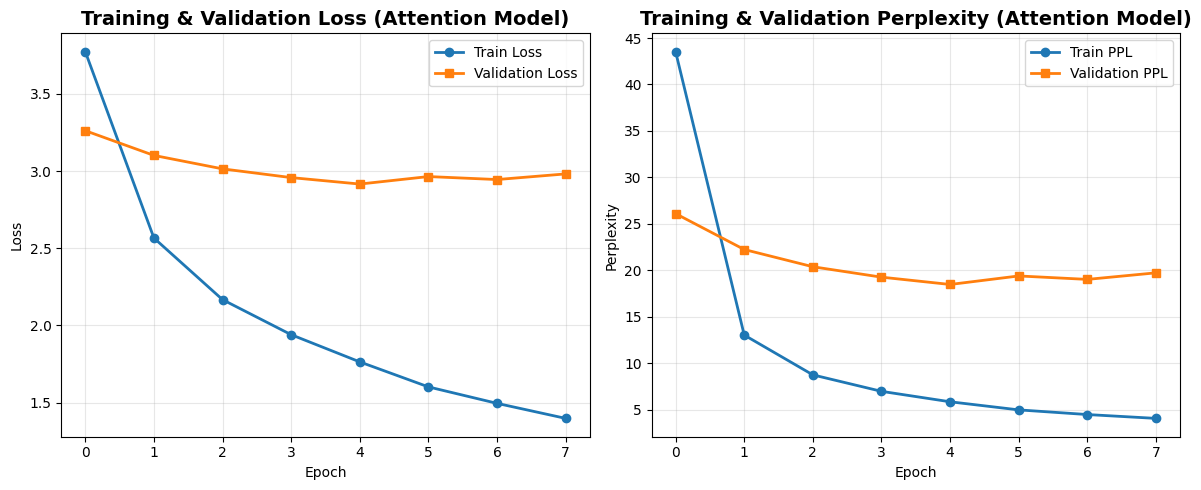

✅ Saved: training_curves_attention_model.png


In [22]:
import matplotlib.pyplot as plt

# Sau khi training hoàn tất, vẽ đường training và validation loss
plt.figure(figsize=(12, 5))

# Vẽ loss cho training
plt.subplot(1, 2, 1)
plt.plot(train_losses_attn, label="Train Loss", marker="o", linewidth=2)
plt.plot(val_losses_attn, label="Validation Loss", marker="s", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss (Attention Model)", fontsize=14, fontweight="bold")
plt.legend()
plt.grid(True, alpha=0.3)

# Vẽ perplexity (PPL) cho training
plt.subplot(1, 2, 2)
train_ppl_attn = [math.exp(x) for x in train_losses_attn]
val_ppl_attn = [math.exp(x) for x in val_losses_attn]
plt.plot(train_ppl_attn, label="Train PPL", marker="o", linewidth=2)
plt.plot(val_ppl_attn, label="Validation PPL", marker="s", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.title("Training & Validation Perplexity (Attention Model)", fontsize=14, fontweight="bold")
plt.legend()
plt.grid(True, alpha=0.3)

# Hiển thị biểu đồ
plt.tight_layout()

# Lưu lại hình ảnh
plt.savefig("training_curves_attention_model.png", dpi=150, bbox_inches="tight")

# Hiển thị biểu đồ
plt.show()

print("✅ Saved: training_curves_attention_model.png")

## 19. So sánh

In [ ]:
import torch
import inspect
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from tqdm.notebook import tqdm

def _decoder_accepts(decoder, name: str) -> bool:
    try:
        return name in inspect.signature(decoder.forward).parameters
    except Exception:
        return False

def _call_decoder(decoder, input_t, hidden, cell, encoder_outputs=None, mask=None):
    kwargs = {}
    # các tên tham số thường gặp ở attention decoder
    if _decoder_accepts(decoder, "encoder_outputs"):
        kwargs["encoder_outputs"] = encoder_outputs
    if _decoder_accepts(decoder, "enc_outputs"):
        kwargs["enc_outputs"] = encoder_outputs
    if _decoder_accepts(decoder, "src_mask"):
        kwargs["src_mask"] = mask
    if _decoder_accepts(decoder, "mask"):
        kwargs["mask"] = mask
    return decoder(input_t, hidden, cell, **kwargs)

@torch.no_grad()
def translate_sentence_auto(model, sentence, src_vocab, trg_vocab, device, max_len=50, pad_idx=0):
    model.eval()

    # input sentence: str hoặc list token
    tokens = tokenize_en(sentence) if isinstance(sentence, str) else sentence
    src_ids = src_vocab.numericalize(tokens)
    if len(src_ids) == 0:
        return []

    src_tensor  = torch.LongTensor(src_ids).unsqueeze(0).to(device)
    src_lengths = torch.LongTensor([len(src_ids)]).to(device)
    mask = (src_tensor != pad_idx)  # [1, src_len]

    need_enc_out = (
        _decoder_accepts(model.decoder, "encoder_outputs")
        or _decoder_accepts(model.decoder, "enc_outputs")
    )

    if need_enc_out:
        hidden, cell, enc_out = model.encoder(src_tensor, src_lengths, return_outputs=True)
    else:
        out = model.encoder(src_tensor, src_lengths, return_outputs=False)
        
        hidden, cell = out[0], out[1]
        enc_out = None

    trg_indexes = [trg_vocab.stoi["<sos>"]]

    for _ in range(max_len):
        input_t = torch.LongTensor([trg_indexes[-1]]).to(device)  # [1]

        dec_out = _call_decoder(
            model.decoder, input_t, hidden, cell,
            encoder_outputs=enc_out, mask=mask
        )

        if isinstance(dec_out, (tuple, list)):
            logits = dec_out[0]
            hidden = dec_out[1]
            cell   = dec_out[2]
        else:
            logits = dec_out

        pred_token = logits.argmax(1).item()
        trg_indexes.append(pred_token)

        if pred_token == trg_vocab.stoi["<eos>"]:
            break

    trg_tokens = [trg_vocab.itos[i] for i in trg_indexes]
    return trg_tokens[1:-1]

def calculate_bleu_auto(data, src_vocab, trg_vocab, model, device, max_samples=None, pad_idx=0, max_len=50):
    if max_samples is not None:
        data = data[:max_samples]

    if data is None or len(data) == 0:
        return 0.0, [], []

    targets, outputs = [], []
    smooth = SmoothingFunction().method4

    for src, trg in tqdm(data, desc="Translating"):
        if trg is None or len(trg) == 0:
            continue

        pred_trg = translate_sentence_auto(
            model, src, src_vocab, trg_vocab, device,
            max_len=max_len, pad_idx=pad_idx
        )

        
        if pred_trg is None or len(pred_trg) == 0:
            continue

        targets.append([trg])
        outputs.append(pred_trg)

    if len(outputs) == 0:
        return 0.0, [], []

    bleu = corpus_bleu(targets, outputs, smoothing_function=smooth) * 100
    return bleu, outputs, targets

print("✅ translate_sentence_auto + calculate_bleu_auto")


✅ FIX ALL loaded: translate_sentence_auto + calculate_bleu_auto


## 20. So sánh trung bình bleu

In [20]:
print("\n" + "="*80)
print("SO SÁNH BLEU: NO-ATTENTION vs ATTENTION")
print("="*80)

MAX_SAMPLES = 500
test_data_full = list(zip(test_en, test_fr))
test_data_used = test_data_full[:MAX_SAMPLES]

print("len(test_en) =", len(test_en))
print("len(test_fr) =", len(test_fr))
print("len(test_data_used) =", len(test_data_used))

PAD_IDX_SRC = en_vocab.stoi["<pad>"]

def eval_bleu_auto(model_obj, ckpt_path):
    model_obj.load_state_dict(torch.load(ckpt_path, map_location=device))
    model_obj.eval()
    bleu, preds, refs = calculate_bleu_auto(
        test_data_used, en_vocab, fr_vocab, model_obj, device,
        max_samples=None, pad_idx=en_vocab.stoi["<pad>"], max_len=50
    )
    return bleu, len(preds)


base_bleu, base_n = eval_bleu_auto(model, "best_model.pth")
attn_bleu, attn_n = eval_bleu_auto(model_attn, "best_attention_model.pth")

print(f"Baseline (no attention) BLEU: {base_bleu:.2f}   | n={base_n}")
print(f"Attention BLEU:               {attn_bleu:.2f}   | n={attn_n}")
print(f"Δ BLEU (attn - base):         {attn_bleu - base_bleu:+.2f}")



SO SÁNH BLEU: NO-ATTENTION vs ATTENTION
len(test_en) = 1000
len(test_fr) = 1000
len(test_data_used) = 500


Translating:   0%|          | 0/500 [00:00<?, ?it/s]

Translating:   0%|          | 0/500 [00:00<?, ?it/s]

Baseline (no attention) BLEU: 34.89   | n=500
Attention BLEU:               42.34   | n=500
Δ BLEU (attn - base):         +7.45
